In [1]:
# Standard library imports
import os

# Third party library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
BLINDED_FILE_PATH = "../datasets/TASK_2/TASK_2/blinded_test_set.csv"
blinded_test_data = pd.read_csv(BLINDED_FILE_PATH)

<Axes: >

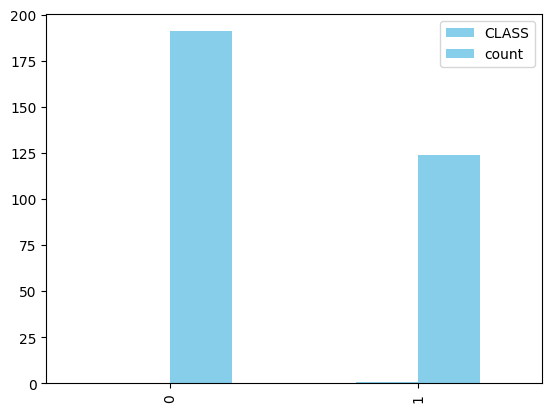

In [3]:
# Reading the csv file
FILE_PATH = "../datasets/TASK_2/TASK_2/train_set.csv"
train_data = pd.read_csv(FILE_PATH)
train_labels = train_data['CLASS'].value_counts().reset_index()
train_labels.plot(kind="bar", color="skyblue")

<Axes: xlabel='CLASS'>

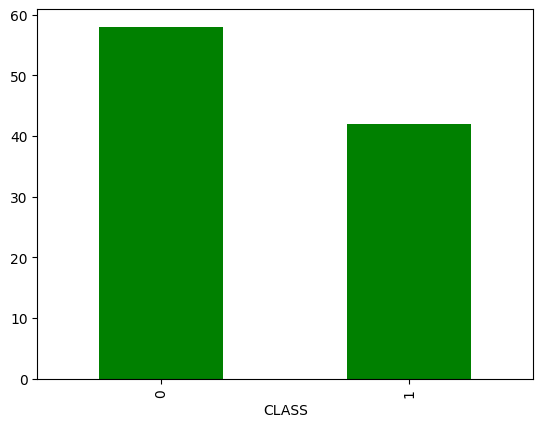

In [4]:
TEST_PATH = "../datasets/TASK_2/TASK_2/test_set.csv"
test_data = pd.read_csv(TEST_PATH)
test_labels = test_data['CLASS'].value_counts()
test_labels.plot(kind="bar", color="green")

In [5]:
X_test = test_data.drop(columns=["ID", "CLASS"])
y_test = test_data["CLASS"]

In [6]:
X_train = train_data.drop(columns=["ID", "CLASS"])
y_train = train_data["CLASS"]

<Axes: >

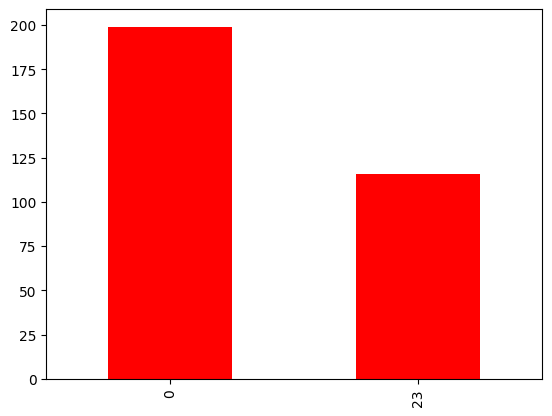

In [7]:
# Check for null values
missing_per_row = X_train.isna().sum(axis=1)
missing_per_row = missing_per_row.value_counts()
missing_per_row.plot(kind="bar", color="red")

<Axes: >

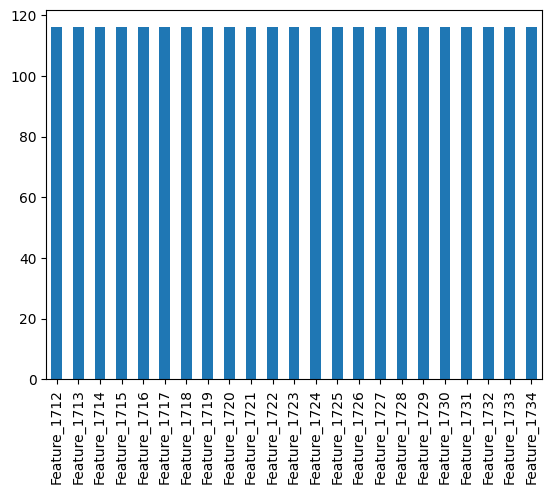

In [8]:
missing_per_column = X_train.isna().sum(axis=0)
missing_per_column = missing_per_column[missing_per_column > 0]
missing_per_column.plot(kind="bar")

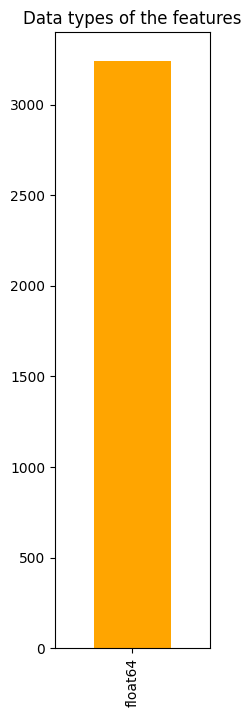

In [9]:
plt.figure(figsize=(2, 8))
feature_dtypes = X_train.dtypes.value_counts()
feature_dtypes.plot(kind="bar", color="orange")
plt.title("Data types of the features")
plt.show()

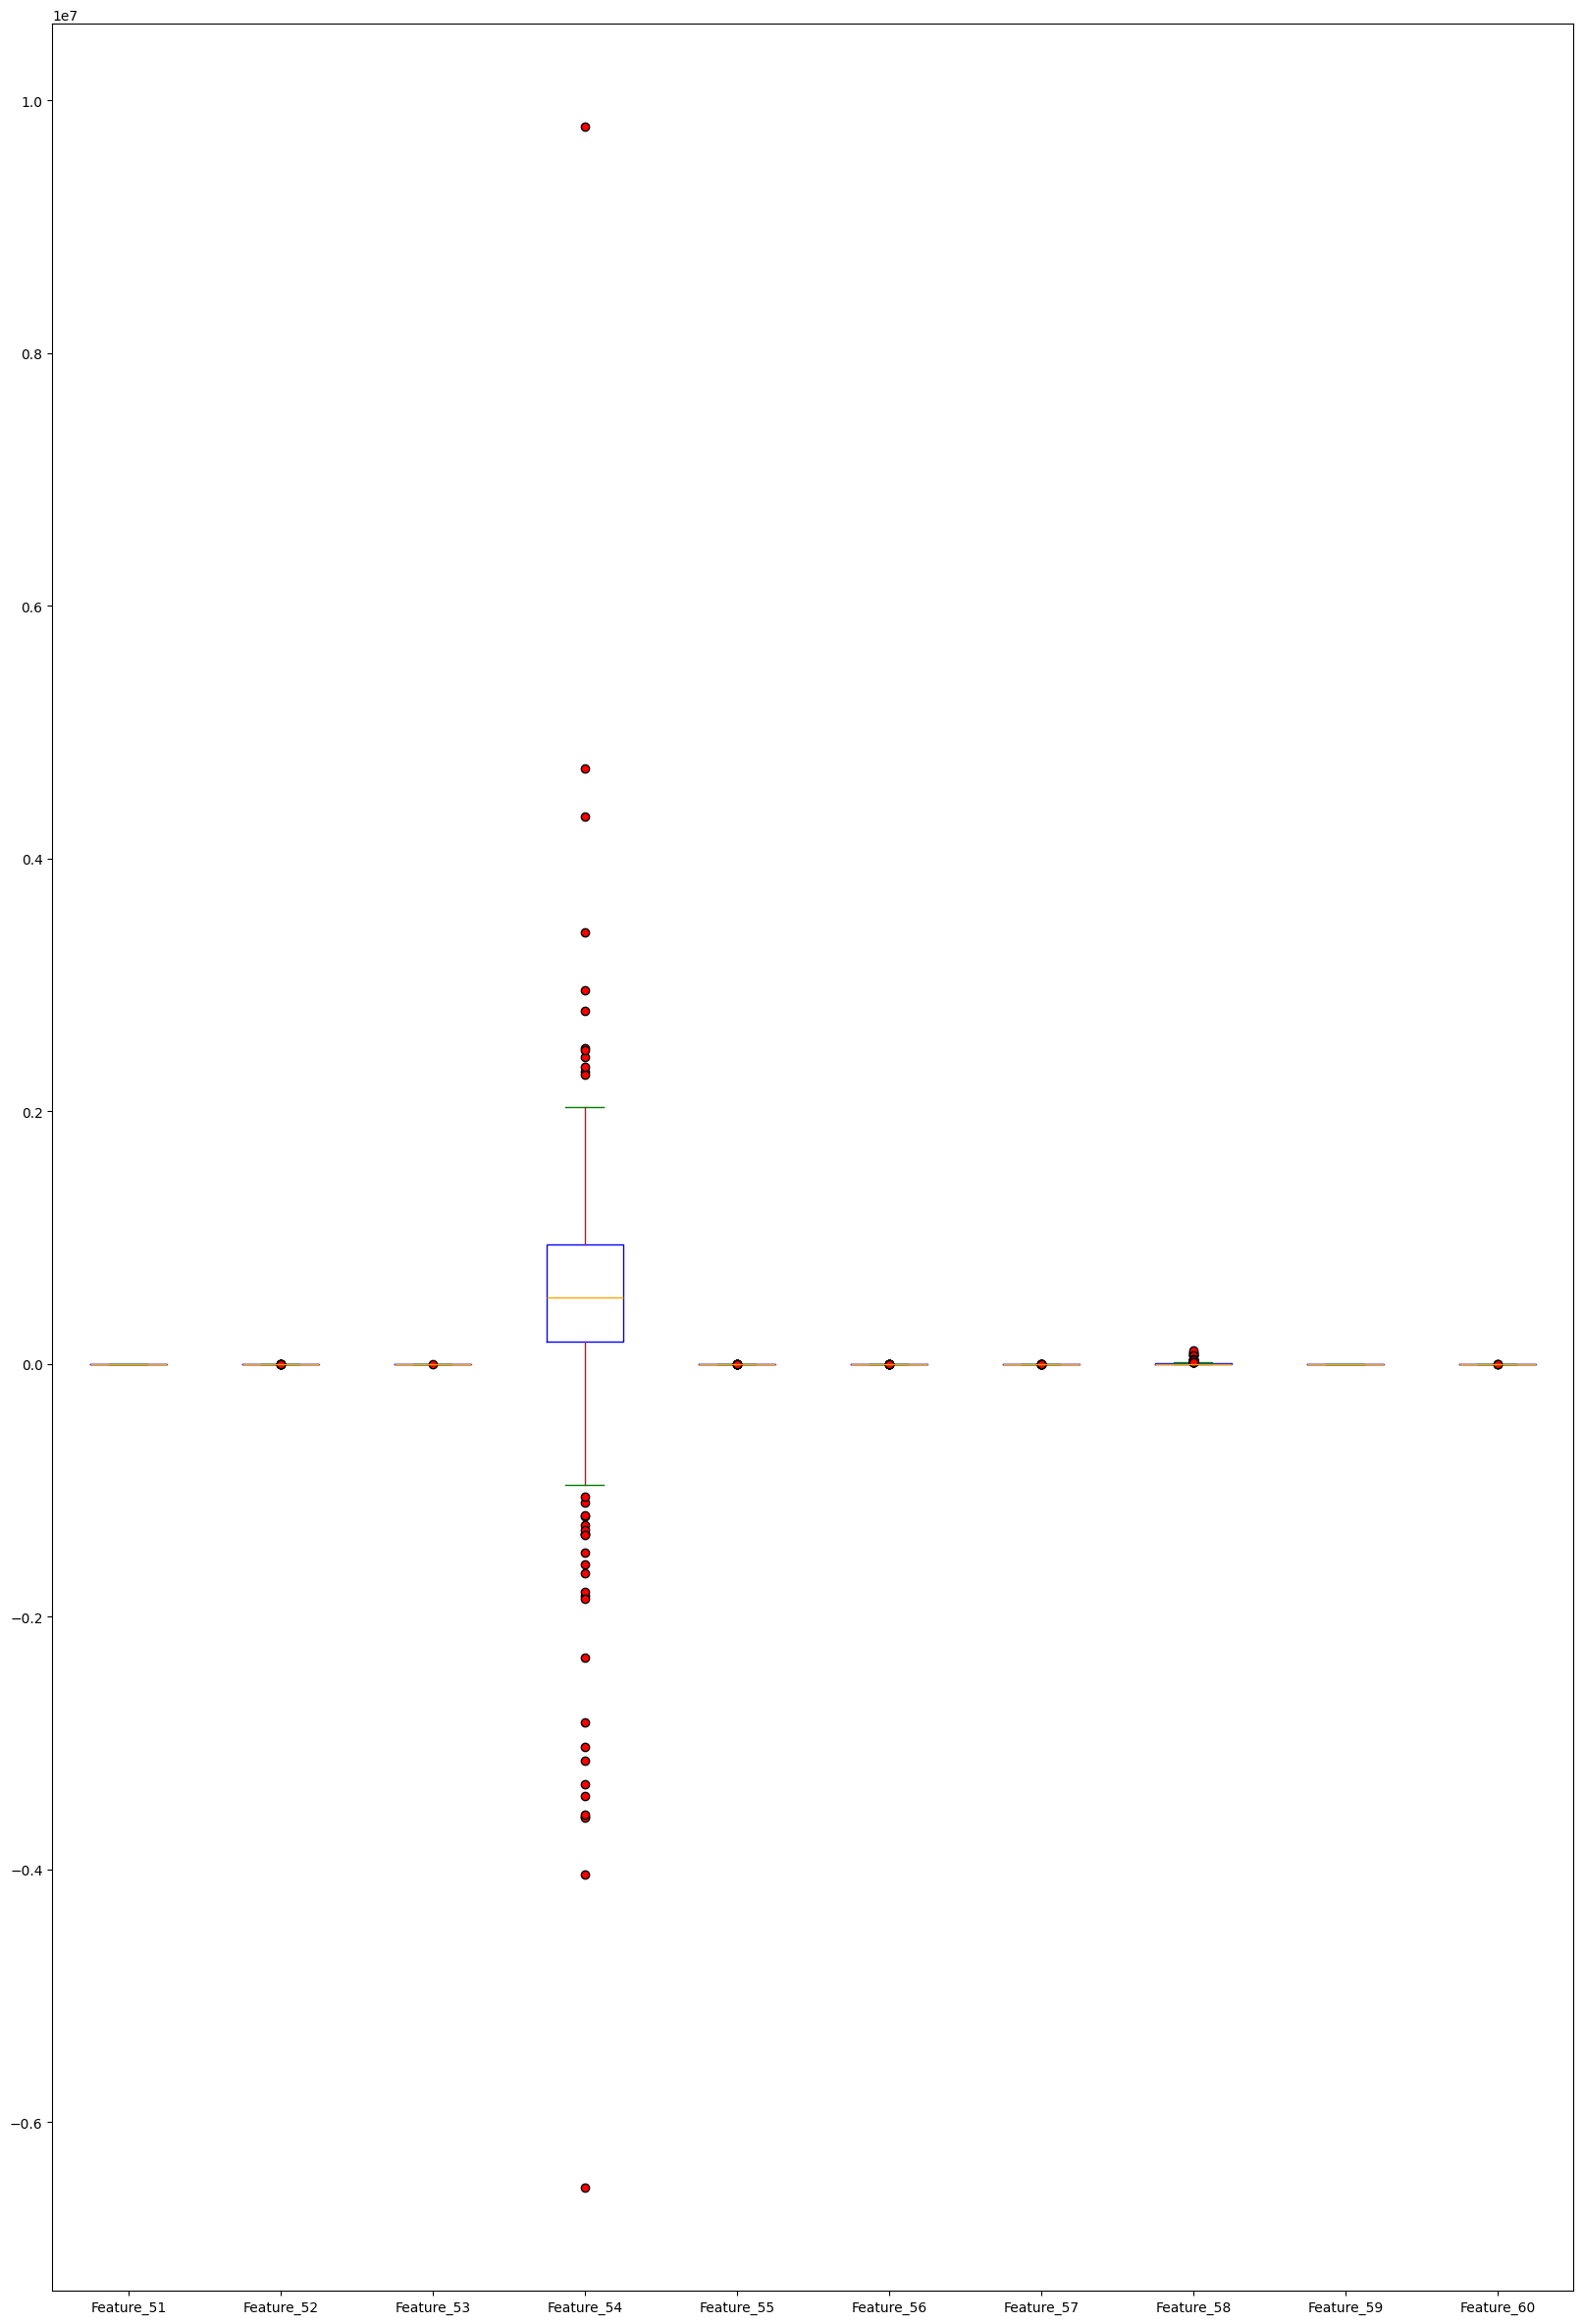

In [10]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_train.iloc[:, 50:60], 
            positions=range(50, 60, 1), 
            tick_labels=X_train.iloc[:, 50:60].columns.to_list(),
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

In [11]:
train_data.select_dtypes(include=['number']).columns

Index(['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5',
       'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10',
       ...
       'Feature_3230', 'Feature_3231', 'Feature_3232', 'Feature_3233',
       'Feature_3234', 'Feature_3235', 'Feature_3236', 'Feature_3237',
       'Feature_3238', 'CLASS'],
      dtype='object', length=3239)

In [12]:
train_dist= train_data["CLASS"].value_counts(normalize=True)
test_dist = test_data["CLASS"].value_counts(normalize=True)
dist_diff = abs(train_dist - test_dist).sum()
if dist_diff > 0.1:
    print(f"Warning: There is a large distribution difference: {dist_diff:.3f}")
else:
    print(f"Distribution difference is acceptable: {dist_diff:.3f}")


Distribution difference is acceptable: 0.053


In [13]:
y_train.isna().sum()

np.int64(0)

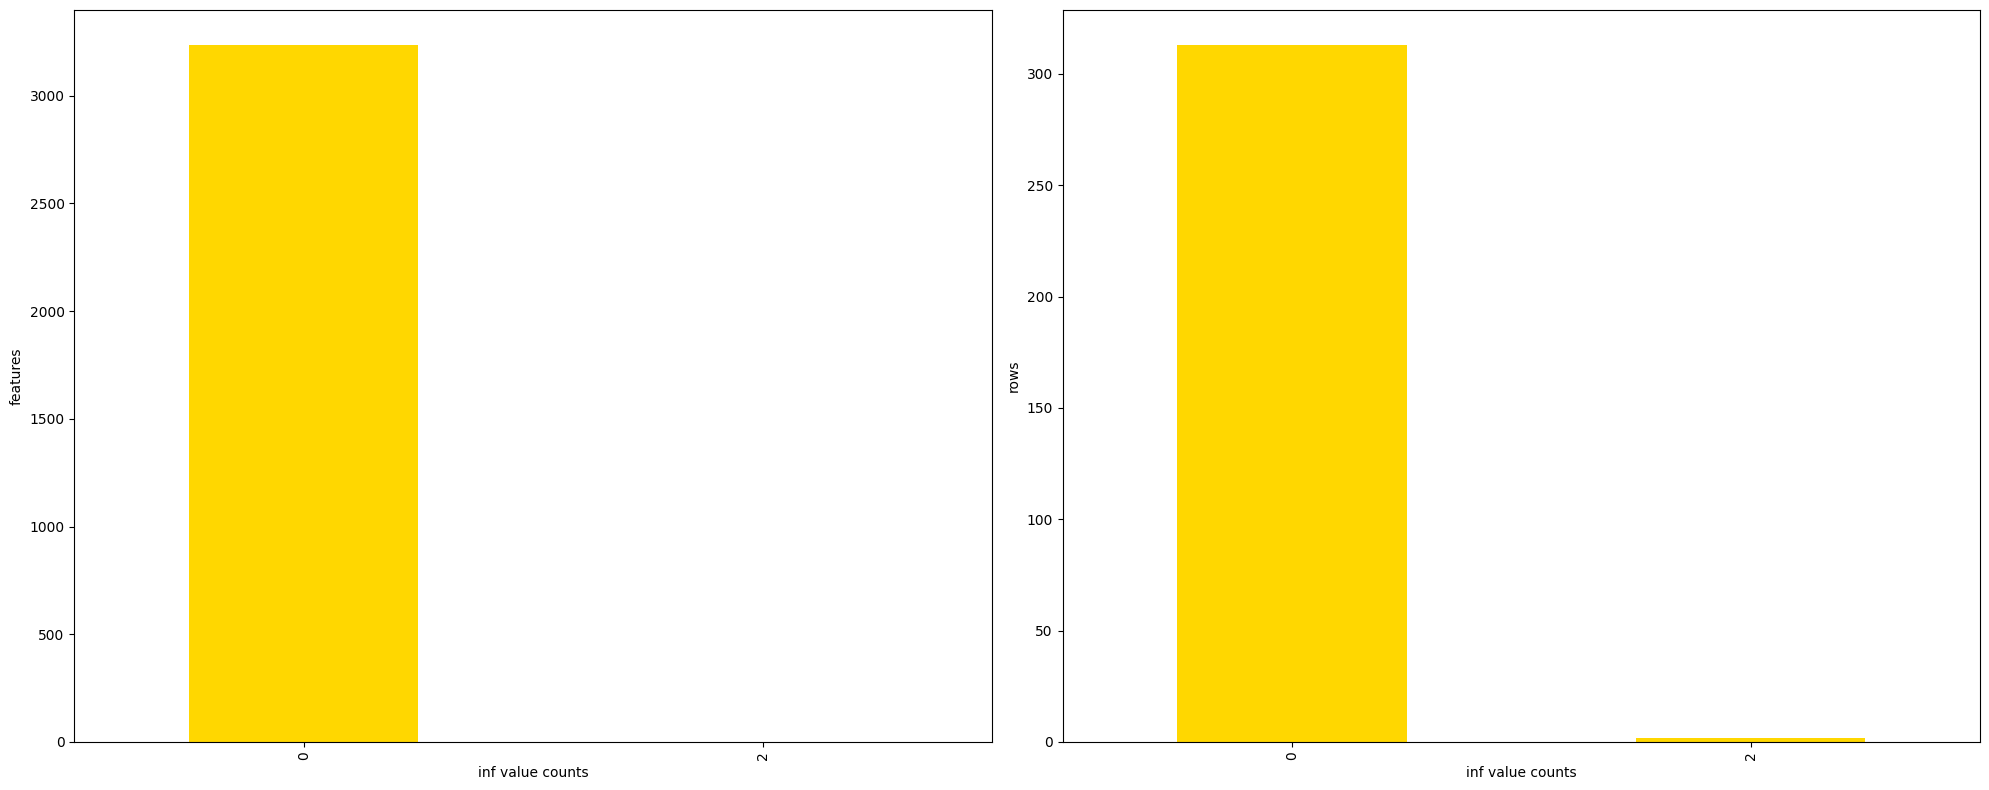

In [14]:
import numpy as np

# Count infinities

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

inf_per_feature = np.isinf(X_train).sum(axis=0).value_counts()
inf_per_feature.plot(kind="bar", color="gold", ax=ax[0])
ax[0].set_xlabel("inf value counts")
ax[0].set_ylabel("features")

inf_per_row = np.isinf(X_train).sum(axis=1).value_counts()
inf_per_row.plot(kind="bar", color="gold", ax=ax[1])
ax[1].set_xlabel("inf value counts")
ax[1].set_ylabel("rows")

plt.tight_layout()
plt.show()


<BarContainer object of 2 artists>

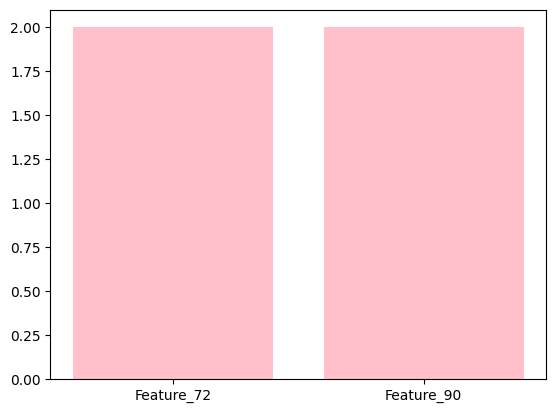

In [15]:
inf_mask = np.isinf(X_train)
inf_summary = inf_mask.sum(axis=0)
features = inf_summary[inf_summary > 0].index.to_list()
plt.bar(features, height=inf_summary[inf_summary > 0].values, color="pink")

In [16]:
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

def visualize_feature(data):
    
    fig, axes = plt.subplots(1, 2, figsize=(10,4))
    sns.scatterplot(data, ax=axes[0])
    axes[0].set_title("Original feature")
    sns.boxplot(x=data, ax=axes[1])
    axes[1].set_title("Box plot")

    plt.tight_layout(pad=0.5)
    plt.show()


In [18]:
from sklearn.impute import SimpleImputer

simple_imputer = SimpleImputer(missing_values=np.nan, strategy="median")
X_imputed = simple_imputer.fit_transform(X_train)
Xt_imputed = simple_imputer.transform(X_test)

In [19]:
X_imputed = pd.DataFrame(X_imputed, columns=X_train.columns)
Xt_imputed = pd.DataFrame(Xt_imputed, columns=X_test.columns)
feature_columns = X_imputed.columns

In [20]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=0.5)
X_var = selector.fit_transform(X_imputed)
Xt_var = selector.transform(Xt_imputed)

print(f"Reduced from {X_imputed.shape[1]} to {X_var.shape[1]} features")

selected_mask = selector.get_support()
selected_features = [feature_columns[i] for i in range(len(selected_mask)) if selected_mask[i]]

X_var = pd.DataFrame(X_var, columns=selected_features)
Xt_var = pd.DataFrame(Xt_var, columns=selected_features)


Reduced from 3238 to 1581 features


In [26]:
corr_matrix = X_var.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X_uncorrelated = X_var.drop(columns=to_drop, axis=1)

In [27]:
uncorrelated_columns = X_uncorrelated.columns

In [28]:
Xt_uncorrelated = Xt_var.drop(columns=to_drop, axis=1)
Xt_uncorrelated

,Feature_1,Feature_3,Feature_10,Feature_11,Feature_13,Feature_14,Feature_27,Feature_55,Feature_57,Feature_58,...,Feature_3108,Feature_3124,Feature_3132,Feature_3137,Feature_3140,Feature_3156,Feature_3188,Feature_3204,Feature_3220,Feature_3236
0,15385.458333,6357.250488,3.165713,128.889395,17.482995,14.444362,6.184611e+05,32.561707,38.565819,517.733276,...,23.414174,49.823700,9.908382,96.682292,57.258646,62.372000,35.419265,31.969241,31.210169,29.952211
1,19539.729167,8168.700928,11.257600,137.432916,26.914001,15.199072,2.523413e+05,33.128307,13.300545,6377.843018,...,23.999956,56.183303,10.731481,132.357506,63.778178,59.465907,33.974920,33.372518,31.625858,31.625858
2,34867.125000,14382.916992,100.627321,247.727673,39.253779,22.395359,1.862830e+05,148.010773,5.342656,576.947876,...,23.332068,53.827111,11.942946,265.748546,67.636049,77.070013,34.608313,32.041778,31.065053,28.805248
3,46112.083333,16512.630859,8.614636,247.103217,45.856962,21.074495,-1.135713e+06,168.510284,-24.629391,4859.756836,...,21.408653,50.038946,9.320589,293.402995,63.254723,69.453816,31.587256,29.016363,27.601655,27.601655
4,37229.000000,12981.727539,10.869511,215.216170,28.984571,27.545766,-6.012861e+06,172.120468,-161.510132,80059.359375,...,21.247095,51.188984,21.437202,269.804796,57.835219,52.785143,32.217626,30.790878,28.207070,28.207070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,41560.708333,16007.148438,26.477994,208.252251,30.902906,25.962195,-5.680349e+05,170.233109,-13.667595,4815.000977,...,22.910825,53.821157,15.418323,260.363740,67.802711,75.767988,33.736069,32.332433,30.470757,30.470757
96,47127.500000,15617.785156,23.197246,218.158199,35.586120,25.525543,1.558956e+06,63.255630,33.079544,594.851013,...,20.424048,43.433289,10.526057,289.256609,56.481908,55.534359,33.620432,30.983333,29.421751,28.104362
97,44099.625000,17311.683594,26.133394,286.567619,45.846735,19.225935,1.107357e+06,28.839373,25.110340,2325.000244,...,21.296958,43.308113,8.574055,260.916458,52.985252,61.402974,31.363993,28.836150,27.852157,27.051511
98,29193.833333,11772.097656,16.133637,222.139596,44.890517,14.535200,9.106550e+05,61.907932,31.193401,625.292603,...,23.066942,47.240634,10.064543,176.022897,54.409788,57.052240,31.971078,29.565275,28.454736,28.454736


In [34]:
def clip_outliers(data, lower_percentile=5, upper_percentile=95):
    temp = data.copy()
    for column in temp.columns:
        Q1 = temp[column].quantile(0.25)
        Q3 = temp[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        temp[column] = np.clip(temp[column], lower_bound, upper_bound)
    return temp

X_clipped = clip_outliers(X_uncorrelated)
Xt_clipped = clip_outliers(Xt_uncorrelated)

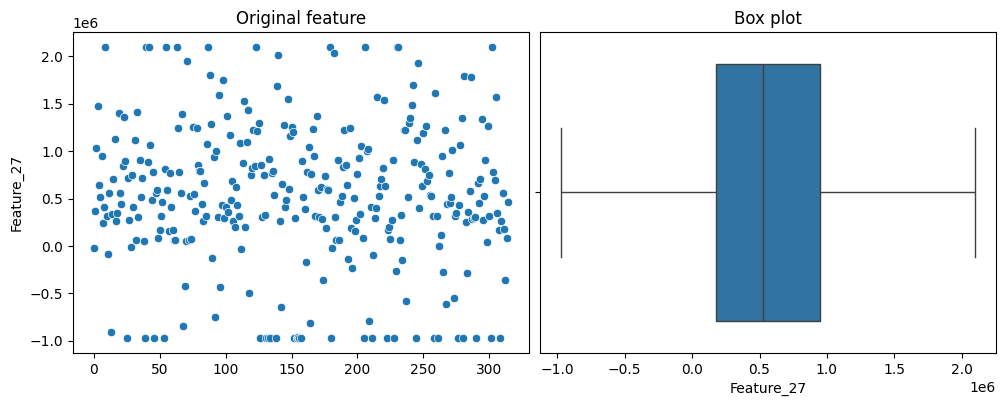

In [50]:
visualize_feature(X_clipped["Feature_27"])

In [27]:
# skewness = abs(X_clipped.skew()) > 1
# skewness[skewness == True].index.to_list()

In [51]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
X_transformed = pd.DataFrame(pt.fit_transform(X_clipped), columns=X_clipped.columns)
Xt_transformed = pd.DataFrame(pt.transform(Xt_clipped), columns=Xt_clipped.columns)


In [52]:
skewness_mask = abs(X_transformed.skew()) > 1
skewed_features = skewness_mask[skewness_mask == True].index.to_list()
X_unskewed = X_transformed.drop(columns=skewed_features)
Xt_unskewed = Xt_transformed.drop(columns=skewed_features)

In [53]:
skewed_features

[]

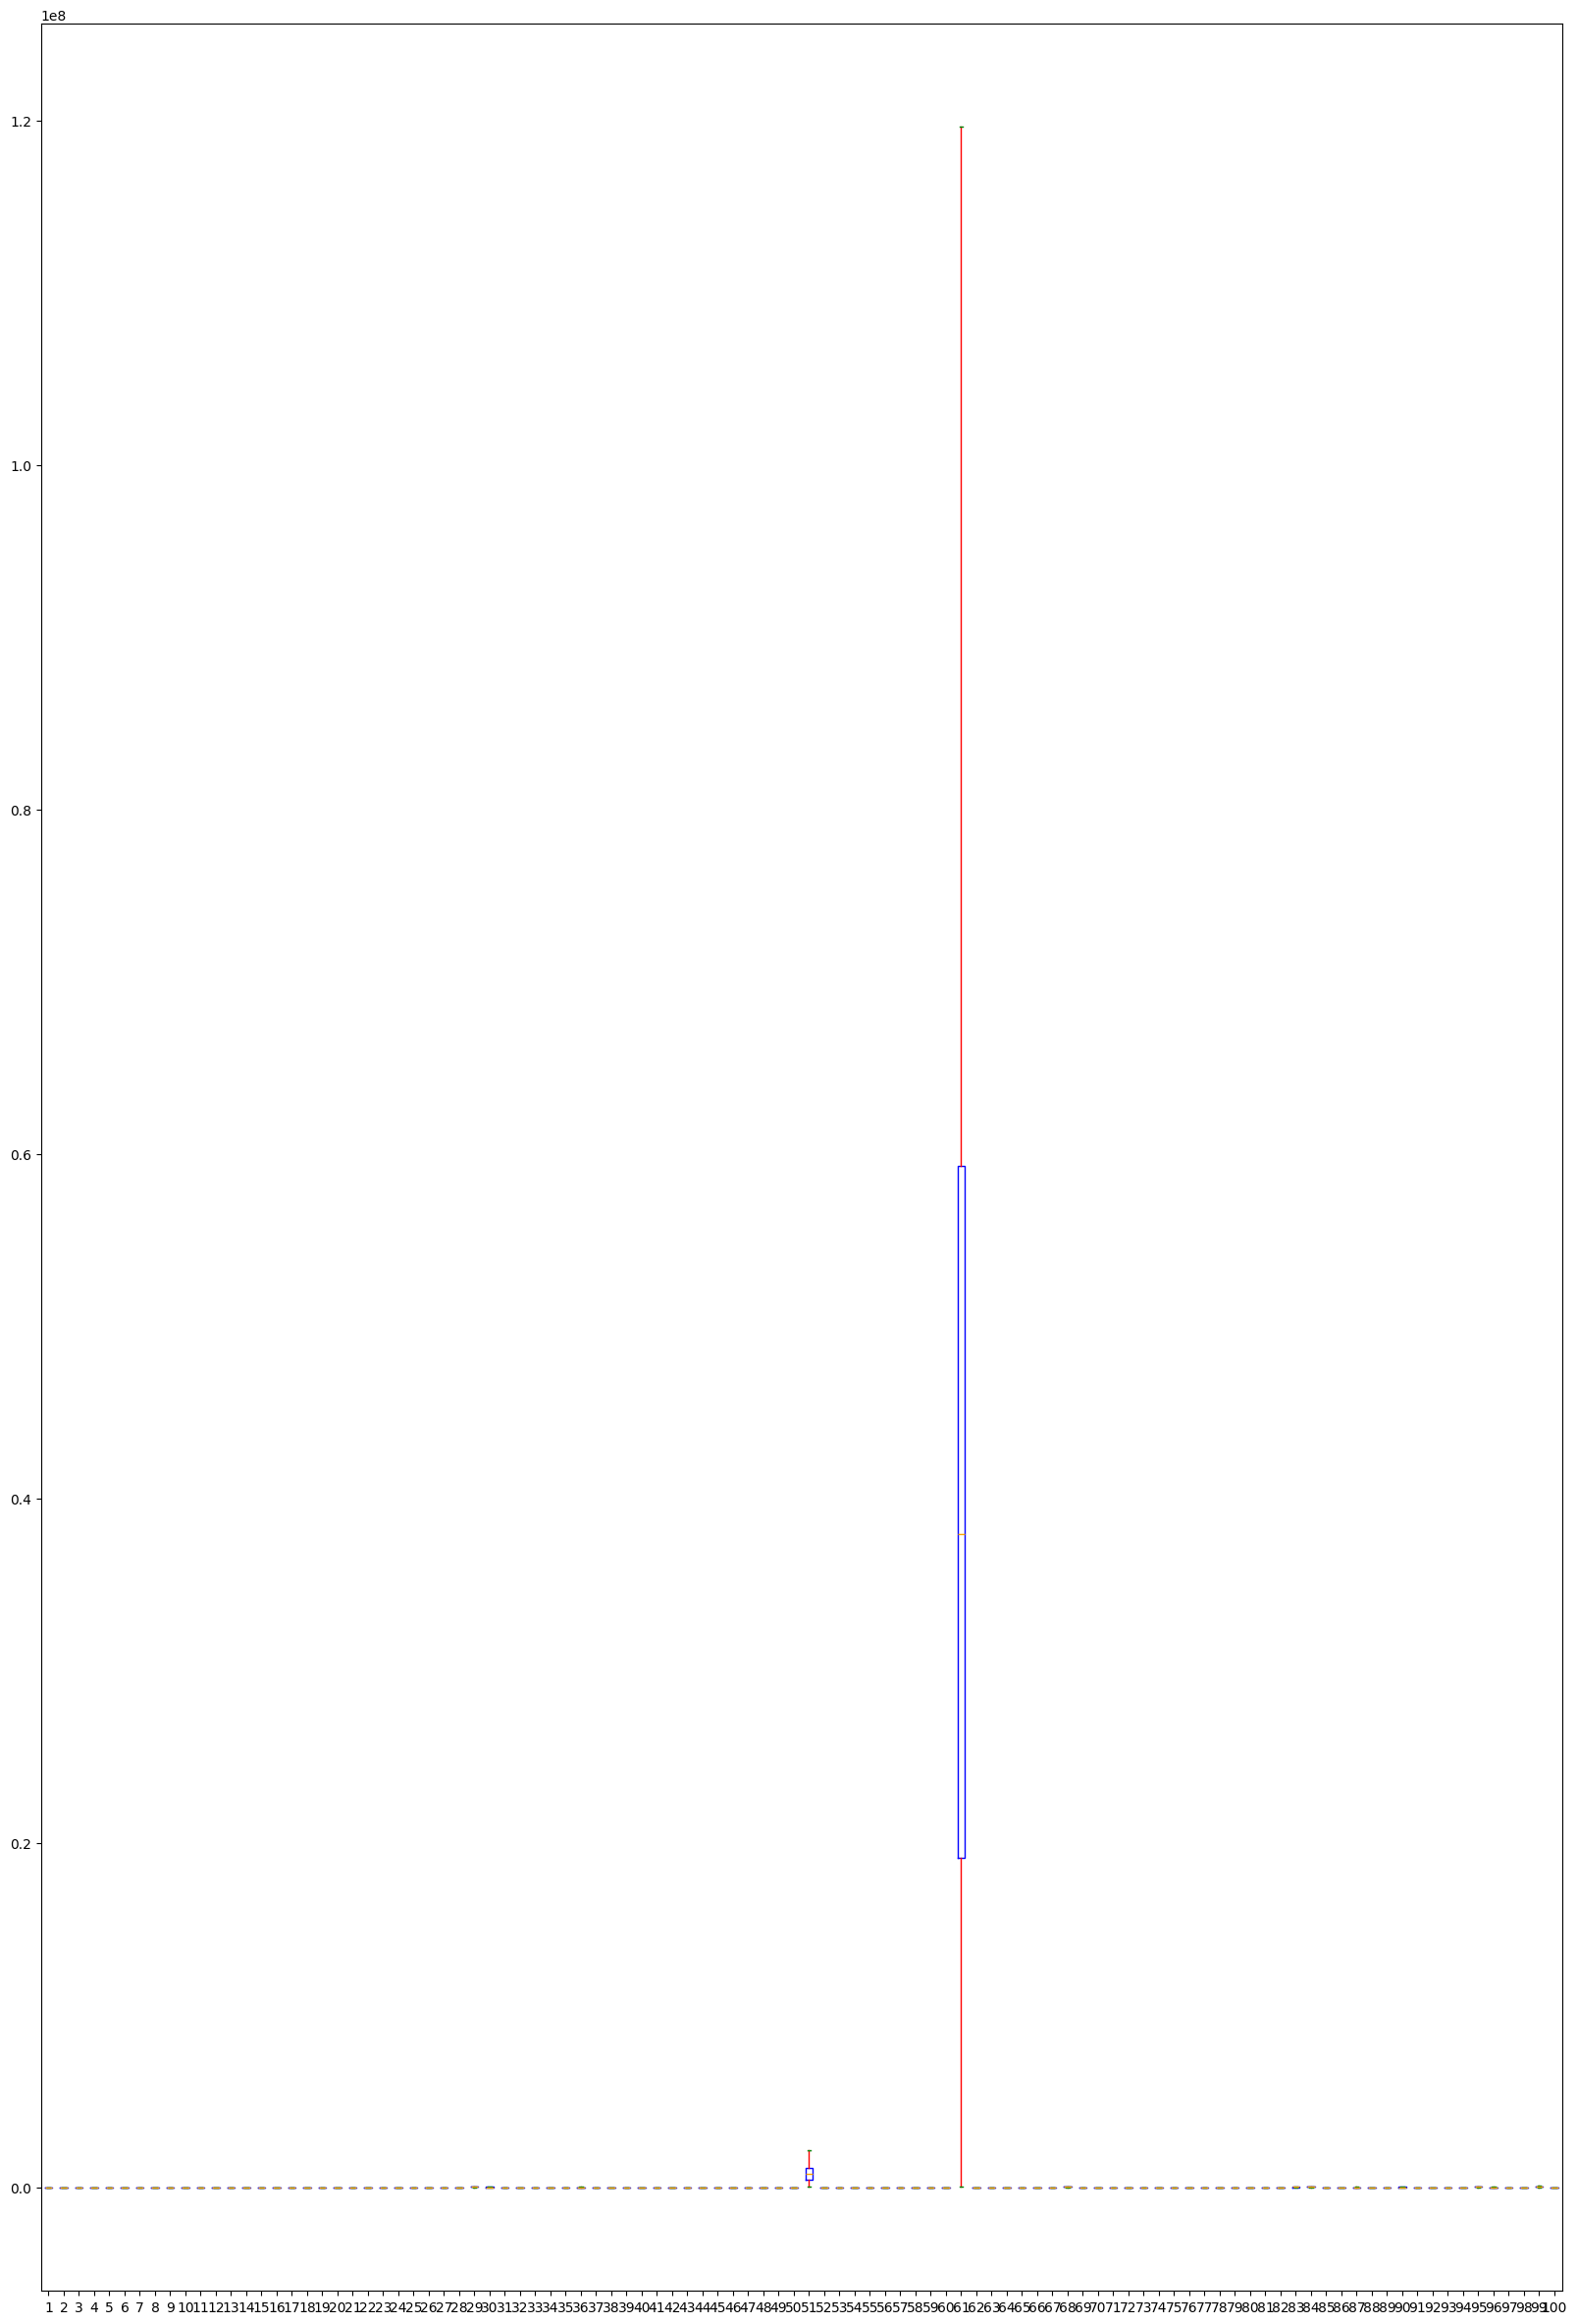

In [45]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_clipped.iloc[:, 100:200], 
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

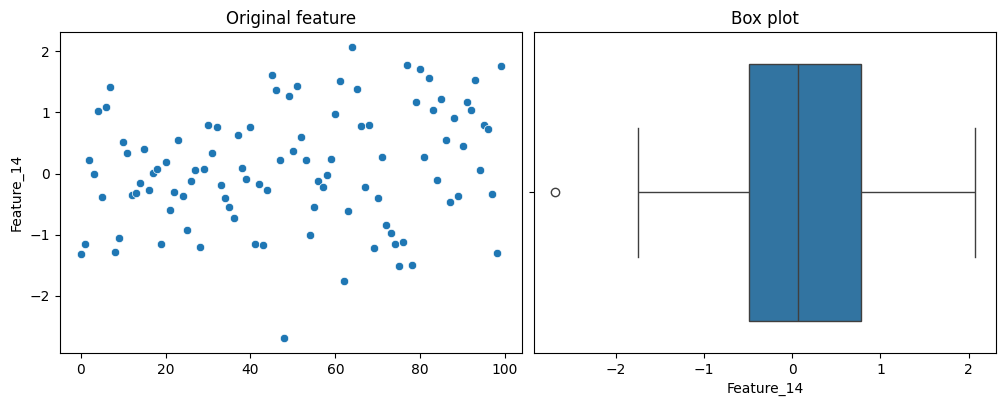

In [61]:
visualize_feature(Xt_unskewed["Feature_14"])

In [62]:
# Detect Outliers
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (data < lower_bound) | (data > upper_bound)

In [63]:
def impute_outliers(data):
    temp = data.copy()
    for column in temp.columns:
        outliers = detect_outliers_iqr(temp[column])
        median_value = temp[column].median()
        temp.loc[outliers.to_list(), column] = median_value
    return temp

X_clean = impute_outliers(X_unskewed)
Xt_clean = impute_outliers(Xt_unskewed)

In [ ]:
X_clipped = clip_outliers(X_unskewed)
Xt_clipped = clip_outliers(Xt_unskewed)

In [94]:
skewness_mask = abs(X_clipped.skew()) > 1
skewed_features = skewness_mask[skewness_mask == True].index.to_list()
X_clipped.drop(columns=skewed_features, inplace=True)
Xt_clipped.drop(columns=skewed_features, inplace=True)

In [98]:
skewed_features

[]

In [96]:
Xt_clipped

,Feature_1,Feature_2,Feature_3,Feature_10,Feature_11,Feature_12,Feature_13,Feature_14,Feature_27,Feature_28,...,Feature_3214,Feature_3215,Feature_3217,Feature_3220,Feature_3224,Feature_3229,Feature_3230,Feature_3231,Feature_3233,Feature_3236
0,-1.306596,-1.307936,-1.430848,-2.102992,-1.291374,-1.251343,-1.751876,-1.317837,0.062687,-1.306596,...,1.681658,-1.774316,-1.209732,0.817935,-0.375665,-0.375665,-0.375665,-1.301255,-1.195840,0.974756
1,-0.958628,-0.959363,-1.046147,-0.937432,-1.284005,-1.251343,-0.996745,-1.149104,-0.475505,-0.958628,...,-0.722398,-0.620323,-0.738428,1.015865,-0.212655,-0.212655,-0.212655,-0.939032,-0.809539,2.057587
2,0.089436,0.090184,0.222878,1.358617,0.900598,1.295237,-0.092567,0.222774,-0.571512,0.089436,...,-0.288184,0.098329,0.034109,0.748225,-0.503480,-0.503480,-0.503480,0.046710,0.056813,0.201175
3,0.721211,0.720611,0.644944,-1.215396,0.883521,0.727383,0.364211,-0.002849,-1.880892,0.721211,...,-0.385898,0.987746,0.830906,-1.018175,0.495731,0.495731,0.495731,0.688446,0.728225,-0.640577
4,0.229372,0.228177,-0.057897,-0.974805,0.085539,-0.059111,-0.839471,1.021315,-1.880892,0.229372,...,-0.261292,0.573351,0.700562,-0.694217,0.793822,0.793822,0.793822,0.259072,0.601026,-0.213187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.475461,0.475722,0.545244,0.058019,-0.069756,-0.118776,-0.695973,0.788063,-1.377466,0.475461,...,-0.485941,0.791939,0.478355,0.459354,0.271332,0.271332,0.271332,0.484768,0.383975,1.315885
96,0.774439,0.773236,0.468250,-0.106391,0.153163,0.009277,-0.353647,0.721962,1.467203,0.774439,...,-0.179527,1.035043,1.097789,-0.064349,1.090179,1.090179,1.090179,0.769625,1.047423,-0.285117
97,0.614042,0.615000,0.801984,0.041568,2.075599,1.698462,0.363516,-0.336092,0.790108,0.614042,...,1.681658,-0.228963,0.396917,-0.883293,-0.215336,-0.215336,-0.215336,0.629928,0.363638,-1.036217
98,-0.266407,-0.266778,-0.302518,-0.538164,0.246596,0.494647,0.298329,-1.297208,0.496587,-0.266407,...,-0.706982,0.101629,0.195762,-0.563655,-0.182918,-0.182918,-0.182918,-0.221641,0.107554,-0.040690


In [40]:
from imblearn.over_sampling import SMOTE
from collections import Counter

counter = Counter(y_train)
print('Before', counter)

smt = SMOTE(random_state=42)
X_sampled, y_sampled = smt.fit_resample(X_uncorrelated, y_train)

counter = Counter(y_sampled)
print('After', counter)


Before Counter({0: 191, 1: 124})
After Counter({0: 191, 1: 191})


In [41]:
from sklearn.preprocessing import RobustScaler

scalar = RobustScaler()
X_scaled = scalar.fit_transform(X_sampled)
Xt_scaled = scalar.transform(Xt_uncorrelated)

In [42]:
# scalar.data_max_, scalar.data_min_

In [43]:
# scalar.mean_, scalar.var_

In [45]:
X_new = pd.DataFrame(X_scaled, columns=X_sampled.columns)
Xt_new = pd.DataFrame(Xt_scaled, columns=Xt_uncorrelated.columns)

In [ ]:
mask = abs(X_new.skew()) > 1
mask[mask==True].sum() #Implies that there are no skewed features left

np.int64(0)

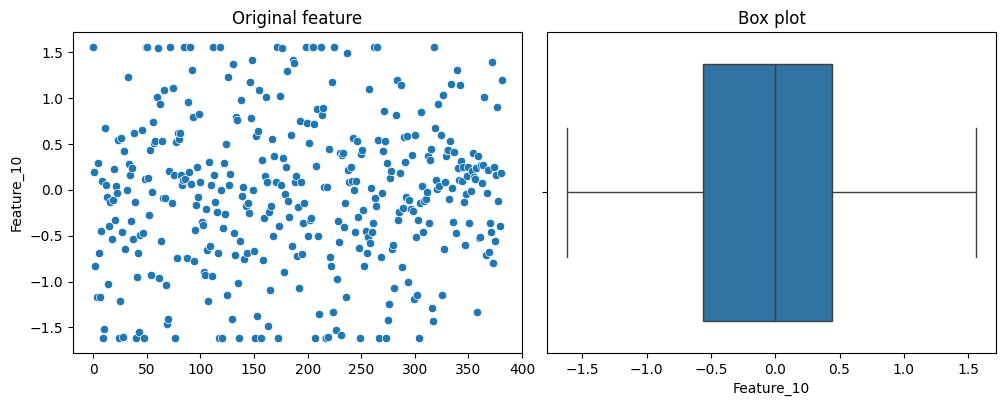

In [53]:
visualize_feature(X_new["Feature_10"])

(array([42., 27., 25., 27., 53., 58., 44., 44., 24., 38.]),
 array([-1.27062229, -1.0312477 , -0.7918731 , -0.55249851, -0.31312391,
        -0.07374932,  0.16562528,  0.40499987,  0.64437446,  0.88374906,
         1.12312365]),
 <BarContainer object of 10 artists>)

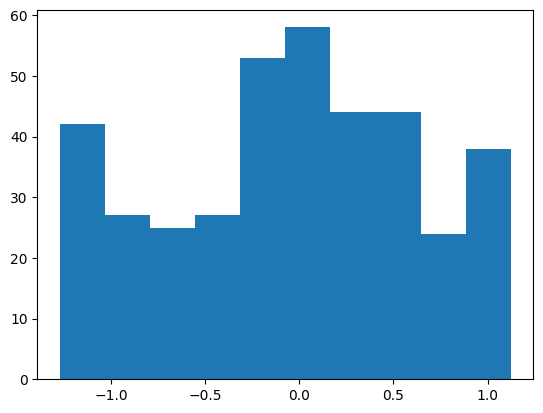

In [55]:
plt.hist(X_new["Feature_200"])

C:\Users\ameer\AppData\Local\Temp\ipykernel_23132\1525360746.py:2: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(X_new.iloc[:, 200:210],


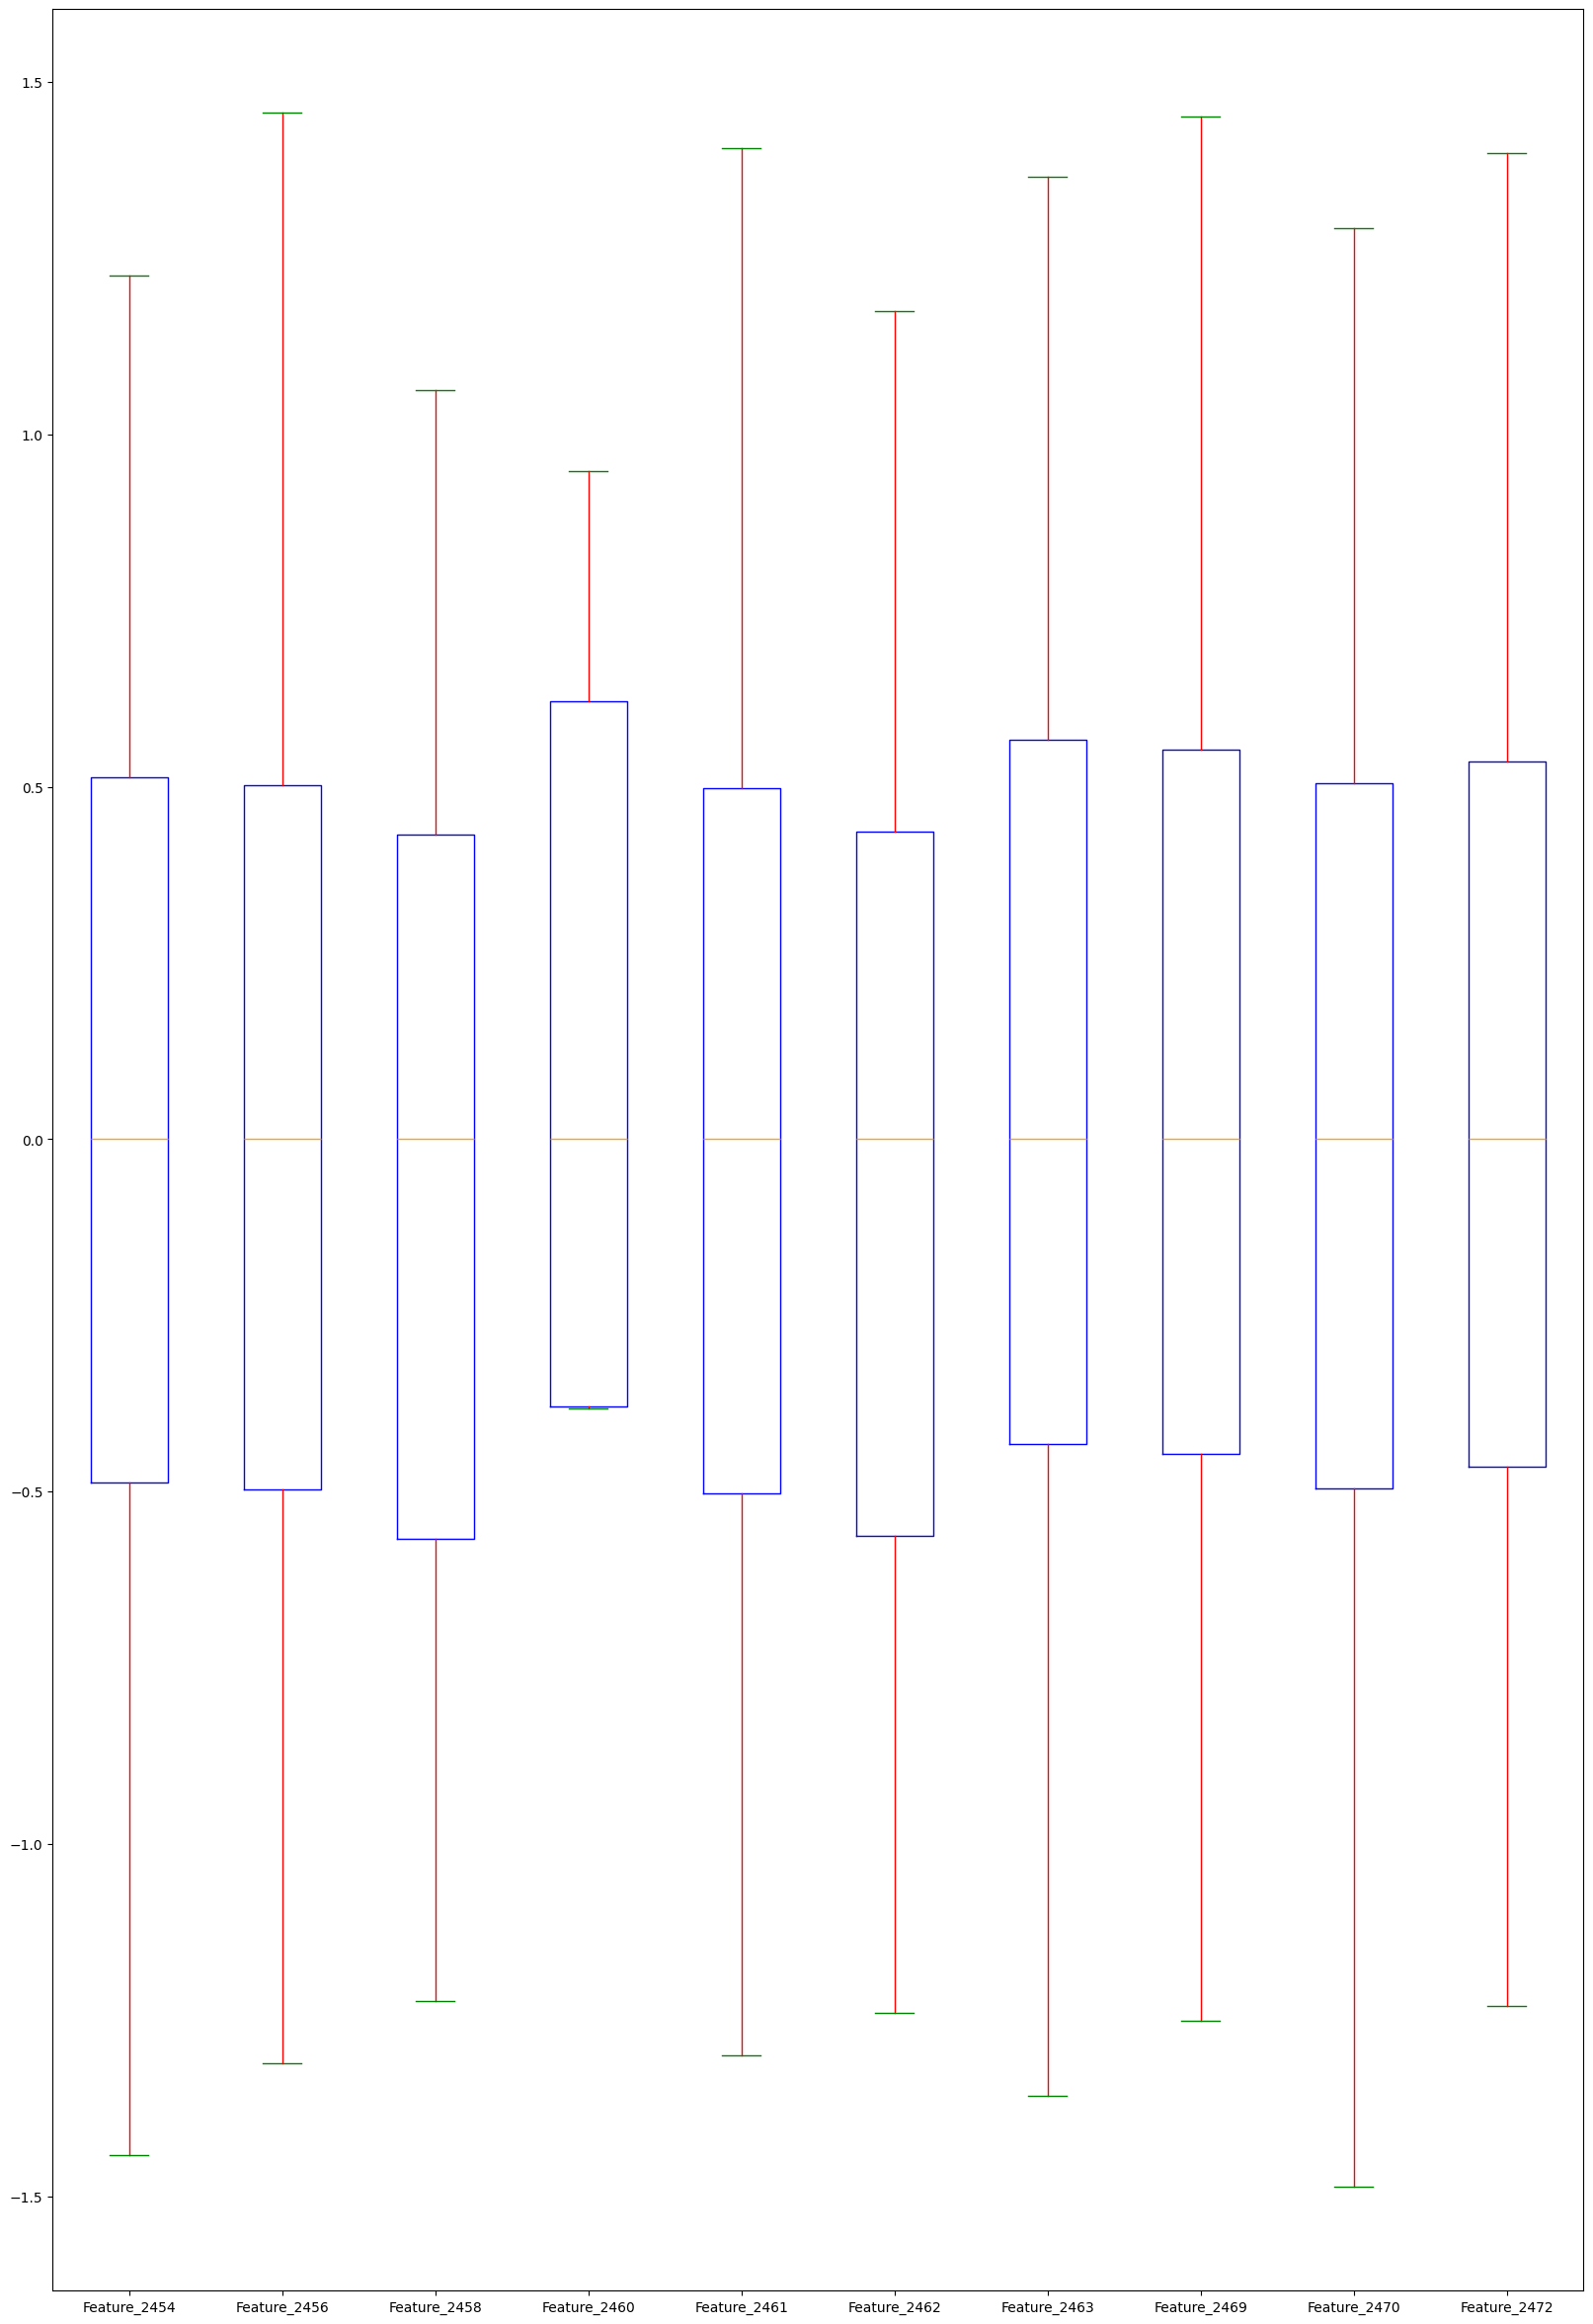

In [52]:
plt.figure(figsize=(20, 30))
plt.boxplot(X_new.iloc[:, 200:210], 
            positions=range(0, 10, 1), 
            labels=X_new.iloc[:, 200:210].columns.to_list(),
            boxprops=dict(color='blue'), 
            whiskerprops=dict(color='red'), 
            capprops=dict(color='green'), 
            medianprops=dict(color='orange'), 
            flierprops=dict(markerfacecolor='red', marker='o'))
plt.show()

In [58]:
new_columns = X_new.columns

In [59]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model = SelectFromModel(clf_rf)
model.fit(X_new, y_sampled)
X_final = model.transform(X_new)
print(X_final.shape)
Xt_final = model.transform(Xt_new)
print(Xt_final.shape)

selected_mask = model.get_support()
selected_rfe_features = [new_columns[i] for i in range(len(selected_mask)) if selected_mask[i]]

(382, 121)
(100, 121)


In [60]:
X_final = pd.DataFrame(X_final, columns=selected_rfe_features)
Xt_final = pd.DataFrame(Xt_final, columns=selected_rfe_features)

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix


clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_final, y_sampled)

y_pred_rf = clf_rf.predict(Xt_final)
print(confusion_matrix(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


[[41 17]
 [20 22]]
              precision    recall  f1-score   support

           0       0.67      0.71      0.69        58
           1       0.56      0.52      0.54        42

    accuracy                           0.63       100
   macro avg       0.62      0.62      0.62       100
weighted avg       0.63      0.63      0.63       100



In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

models_config = {

    'Logistic Regression': {

        'model': LogisticRegression(random_state=42, max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1, 10, 100],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        }
    },

    # 'Random Forest': {

    #     'model': RandomForestClassifier(random_state=42, n_estimators=100),
    #     'params':{
    #         'n_estimators': [100, 200, 300],
    #         'max_depth': [None, 5, 10, 20],
    #         'min_samples_split': [2, 5, 10, 20],
    #         'min_samples_leaf': [1, 2, 4, 8],
    #         'max_features': ['sqrt', 'log2']
    #     }
    # },

    'Decision Tree': {

        'model': DecisionTreeClassifier(random_state=42),

        'params':  {
            'criterion': ['gini', 'entropy', 'log_loss'],
            'max_depth': [5, 10, 20, 30],
            'min_samples_split': [2, 4, 8, 10],
            'min_samples_leaf': [1, 2, 3, 4],
            'max_features': [None, 'sqrt', 'log2'],
        }

    }

}

In [63]:
models_config

{'Logistic Regression': {'model': LogisticRegression(max_iter=2000, random_state=42),
  'params': {'C': [0.01, 0.1, 1, 10, 100],
   'penalty': ['l1', 'l2'],
   'solver': ['liblinear', 'saga']}},
 'Decision Tree': {'model': DecisionTreeClassifier(random_state=42),
  'params': {'criterion': ['gini', 'entropy', 'log_loss'],
   'max_depth': [5, 10, 20, 30],
   'min_samples_split': [2, 4, 8, 10],
   'min_samples_leaf': [1, 2, 3, 4],
   'max_features': [None, 'sqrt', 'log2']}}}

In [64]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = dict()

for name, config in models_config.items():

    print(f"Training {name}...")
    grid_search = GridSearchCV(estimator=config['model'], param_grid=config['params'], cv=cv, n_jobs=-1, scoring='f1', verbose=0)
    grid_search.fit(X_final, y_sampled)
    models[name] = {
            'model': grid_search.best_estimator_,
            'best_params': grid_search.best_params_,
            'cv_score': grid_search.best_score_
        }   

    if name in models: 
        print(f"Best CV Score: {models[name]["cv_score"]:.4f}")
        print(f"Best Parameters: {models[name]["best_params"]}")

Training Logistic Regression...


Best CV Score: 0.6853
Best Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}
Training Decision Tree...
Best CV Score: 0.6802
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10}


In [65]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

results = {}

for name, model_info in models.items():
    model = model_info['model']

    y_pred = model.predict(Xt_final)
    y_pred_proba = model.predict_proba(Xt_final)[:, 1] if hasattr(model, 'predict_proba') else None

    accuracy = accuracy_score(y_test, y_pred)

    results[name] = {

        'accuracy': accuracy,
        'cv_score': model_info['cv_score'],
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"\n{name}:")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"CV Score: {model_info['cv_score']:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    



Logistic Regression:
Test Accuracy: 0.6300
CV Score: 0.6853

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.64      0.67        58
           1       0.55      0.62      0.58        42

    accuracy                           0.63       100
   macro avg       0.63      0.63      0.63       100
weighted avg       0.64      0.63      0.63       100


Decision Tree:
Test Accuracy: 0.5200
CV Score: 0.6802

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.40      0.49        58
           1       0.45      0.69      0.55        42

    accuracy                           0.52       100
   macro avg       0.55      0.54      0.52       100
weighted avg       0.56      0.52      0.51       100



In [66]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=1000, C= 1, penalty='l2', solver='liblinear')
clf_lr.fit(X_final, y_sampled)

y_pred_lr = clf_lr.predict(Xt_final)
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

[[36 22]
 [22 20]]
              precision    recall  f1-score   support

           0       0.62      0.62      0.62        58
           1       0.48      0.48      0.48        42

    accuracy                           0.56       100
   macro avg       0.55      0.55      0.55       100
weighted avg       0.56      0.56      0.56       100



In [67]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_final, y_sampled)

y_pred_dt = clf_dt.predict(Xt_final)
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


[[31 27]
 [23 19]]
              precision    recall  f1-score   support

           0       0.57      0.53      0.55        58
           1       0.41      0.45      0.43        42

    accuracy                           0.50       100
   macro avg       0.49      0.49      0.49       100
weighted avg       0.51      0.50      0.50       100



In [70]:
# Check feature distributions

feature_drift_count = 0

for col in selected_rfe_features:
    train_mean = X_final[col].mean()
    test_mean = Xt_final[col].mean()
    train_std = X_final[col].std()

    if train_std > 0:
        z_score = (train_mean - test_mean) / train_std
        if z_score > 2:
            feature_drift_count += 1

if feature_drift_count > len(selected_rfe_features) * 0.2:
    print(f"Warning: {feature_drift_count} features show significant distribution drift")
else:
    print(f"Feature distributions look stable ({feature_drift_count} potential drift)")

Feature distributions look stable (0 potential drift)


In [72]:
# Check for overfitting

for name, model_info in models.items():
    model = model_info['model']
    train_pred = model.predict(X_final)
    train_acc = accuracy_score(y_sampled, train_pred)

    test_pred = model.predict(Xt_final)
    test_acc = accuracy_score(y_test, test_pred)

    overfitting = abs(train_acc - test_acc)
    print(f"{name}: Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.3f}, Overfitting: {overfitting:.3f}")

    if overfitting > 0.1:
        print(f"Potential overfitting detected for {name} model")

Logistic Regression: Train Accuracy: 0.709, Test Accuracy: 0.630, Overfitting: 0.079
Decision Tree: Train Accuracy: 0.757, Test Accuracy: 0.520, Overfitting: 0.237
Potential overfitting detected for Decision Tree model


In [74]:
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=42)
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(clf, X_final, y_sampled, cv=kf, scoring="accuracy")